## Lämmityksen kustannusvertailu:
    

Vertailtavat lämmitystavat:
1. <b>Suora sähkölämmitys kiinteä sopimus</b> <br>
2. <b>Suora sähkölämmitys pörssisähkösopimus</b><br>
3. <b>Varaava sähkölämmitys yösähköllä</b><br>
4. <b>Varaava sähkölämmitys yösähköllä ja "älykkäällä" ohjauksella</b><br>
5. <b>VILP pörssisähköllä</b><br>
6. <b>VILP kiinteä sopimus</b><br>

In [1]:
import pandas as pd
import math

Tiedot joilla talon kulutus arvioidaan:

In [2]:
vuosikulutuksen_vuosi = '2022-2021'
vuosikulutus_kWh = 25000
vuosikulutuksen_sisälämpötila = 20
lampiman_kayttoveden_lampotila = 60
lampiman_kayttoveden_vuosikulutus_m3 = 100
# Säätietojen tiedostonimet
data_lista = ["2022-2021", "2021-2020", "2020-2019"]

Talon lämpöresistanssin määrittäminen:

In [3]:
df = pd.read_csv(vuosikulutuksen_vuosi + ".csv")
df.rename(columns={'Ilman lämpötila (degC)': 'Temp'}, inplace=True)
dT_list = []
for index, rows in df.iterrows():
    dT = max(0, vuosikulutuksen_sisälämpötila-float(rows.Temp))
    dT_list.append(dT)
dT_sum = sum(dT_list)
R_th = dT_sum/vuosikulutus_kWh # K/kW
print("Talon lämpöresistanssi on " + str(R_th/1000) + " K/W.")

Talon lämpöresistanssi on 0.03110272799999955 K/W.


Patterien lämpöresistanssin määrittäminen:

In [4]:
#Empiirinen havainto: -20 säässä menoveden lämpötila on 60 C
P_lämpöhäviö = (vuosikulutuksen_sisälämpötila - -20)/R_th
Rth_patterit = P_lämpöhäviö/(60-vuosikulutuksen_sisälämpötila)
print("Patterien lämpöresistanssi on " + str(Rth_patterit/1000) + " K/W")

def menoveden_lämpötila(sisälämpötila, tehohäviö):
    return sisälämpötila + tehohäviö/Rth_patterit

Patterien lämpöresistanssi on 3.215152059973693e-05 K/W


Lämpöpumpun ominaisuudet:

In [5]:
# Syötteenä ulkolämpötila ja menevän patteriveden lämpötila, palauttaa COP:n
def lämpöpumppu(ulkolämpötila, vedenlämpötila):
    höyrystymislämpötila = ulkolämpötila -10
    #R410A
    höyrystymispaine = (höyrystymislämpötila**3)*1.506*(10**-5)+(höyrystymislämpötila**2)*0.003139+höyrystymislämpötila*0.25468+7.98982
    lauhtumislämpötila = vedenlämpötila+5
    lauhtumispaine = (lauhtumislämpötila**3)*1.506*(10**-5)+(lauhtumislämpötila**2)*0.003139+lauhtumislämpötila*0.25468+7.98982
    painesuhde = lauhtumispaine/höyrystymispaine
    hyvyysluku = 0.63
    taikaluku1 = 3.68*5.37
    cop = taikaluku1*hyvyysluku/painesuhde
    return max(1, cop)

Laskennassa käytetyt vakiot:

In [6]:
sähkösopimus_perusmaksu_kk = 2.9 #€/kk
sähkösopimus_hinta_per_kwh = 0.13 #€/kwh

sähkösopimus_pörssi_perusmaksu_kk = 3.9 # €/kk
pörssisähkö_marginaali_kwh = 0.003 #€/kwh

sähkönsiirto_perusmaksu_kk = 3.0 #€/kk
sähkönsiirto_hinta_per_kwh = 0.035 #€/kwh

sähkönsiirto_perusmaksu_kk_yö = 10.5 # €/kk
sähkönsiirto_hinta_per_kwh_yö_yö = 0.0135 # €/kwh
sähkönsiirto_hinta_per_kwh_yö_päivä = 0.032 # €/kwh

energiavaraajan_koko = 100 # kwh

Sähkön pörssihintadatan lukeminen:

In [7]:
df_porssi = pd.read_pickle("porssidata")
avain_lista = []
hinta_lista = []
for index, rows in df_porssi.iterrows():
    avain_lista.append(rows.Vuosi+rows.Kuukausi+rows.Paiva+rows.Kellonaika)
    hinta_lista.append(rows.Hinta)
hinta_dict = dict(zip(avain_lista, hinta_lista))

temp = {}
for key,value in hinta_dict.items():
    if key not in temp.keys():
        temp[key] = value
hinta_dict = temp

Kulutusten laskenta:

In [8]:
class vuosikulutus:
        def __init__(self, vuosi, sisälämpötila, sulakekoko = 25):
            self.vuosi = vuosi
            self.sisälämpötila = sisälämpötila
            self.kulutus = 0
            self.sähkösopimus_kwh = 0
            self.sähkönsiirto_kwh = 0
            self.sähkösopimus_perusmaksu = 0
            self.sähkönsiirto_perusmaksu = 0
            self.kokonaiskustannus = 0
            self.df = pd.DataFrame()
            self.edellinen_hinta = 0
            self.varaajassa_oleva_energia = 0
            self.maksimiteho = (sulakekoko*230*3-1000)/1000 # Vakio 1kW varaus muille kuormille
            self.alyohjaus_avainlista = []
            self.alyohjaus_tuntivalinnat_tehty = 0
            
        def kustannus_kiintea_sopimus(self, rows):
            sähkösopimus_kk = sähkösopimus_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            sähkösopimus_kwh = energia*sähkösopimus_hinta_per_kwh
            sähkönsiirto_kwh = energia*sähkönsiirto_hinta_per_kwh
            return dT, energia, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk
            
        def kustannus_porssisahko(self, rows):
            sähkösopimus_kk = sähkösopimus_pörssi_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            kello = rows.Klo.split(":")[0]

            Vuosi = str(rows.Vuosi)
            Kk = str(0)+str(rows.Kk) if len(str(rows.Kk))==1 else str(rows.Kk)
            Pv = str(0)+str(rows.Pv) if len(str(rows.Pv))==1 else str(rows.Pv)
            key = Vuosi+Kk+Pv+kello
            try:
                hinta = hinta_dict[key]
                self.edellinen_hinta = hinta
            except KeyError:
                hinta = self.edellinen_hinta

            sähkösopimus_kwh = energia*((hinta/100)+pörssisähkö_marginaali_kwh)
            sähkönsiirto_kwh = energia*sähkönsiirto_hinta_per_kwh
            return dT, energia, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk

        def kustannus_aly_yosahko(self, rows): 
            sähkösopimus_kk = sähkösopimus_pörssi_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk_yö*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            
            kello = rows.Klo.split(":")[0]
            Vuosi = str(rows.Vuosi)
            Kk = str(0)+str(rows.Kk) if len(str(rows.Kk))==1 else str(rows.Kk)
            Pv = str(0)+str(rows.Pv) if len(str(rows.Pv))==1 else str(rows.Pv)
            avain = Vuosi+Kk+Pv+kello
            
            
            #Valitaan yösähkön halvimmat tunnit
            if (int(kello) >= 22 and self.älyohjaus_tuntivalinnat_tehty == 0):
                #0.9 on varmuuskerroin joka varautuu siihen, että yöllä on kymempää kuin klo 22
                teho_käytettävissa = max(0, (self.maksimiteho - energia))*0.9 
                energian_tarve = energiavaraajan_koko - self.varaajassa_oleva_energia
                tarvittavien_tuntien_määrä = int(energian_tarve/teho_käytettävissa)+1
                
                #Listataan kaikki tunnit muodossa jossa dict:stä voi hakea
                alku = Vuosi+Kk+Pv
                avain_lista = [alku + kello, alku + str(int(kello)+1)]
                for i in range(0, 7, 1):
                    avain_lista.append(str(int(alku)+1)+'0'+str(i))
                hinta_lista_tuple = []
                edellinen = 0
                # Listataan hinnat dictiin.
                for avain1 in avain_lista:
                    try:
                        edellinen = hinta_dict[avain1]
                    except KeyError:
                        pass
                    hinta_lista_tuple.append((avain1, edellinen))

                #Järjestetään dict hinnan mukaan halvin ensin ja valitaan tarvittava määrä tunteja    
                hinta_lista_tuple1 = sorted(hinta_lista_tuple, key=lambda tup: tup[1])
                hinta_lista_tuple = hinta_lista_tuple1[:tarvittavien_tuntien_määrä]
                self.alyohjaus_avainlista = []
                for tup in hinta_lista_tuple:
                    self.alyohjaus_avainlista.append(tup[0])
                self.älyohjaus_tuntivalinnat_tehty = 1
            
            #Sama kuin yösähkössä, mutta varaajan täyttöä säännöstellään avain_lista[]:n perusteella
            if (22 <= int(kello) or int(kello) <= 6):
                if avain in self.alyohjaus_avainlista:
                    kulutus = energia + (energiavaraajan_koko - self.varaajassa_oleva_energia)
                    kulutus = min(kulutus, self.maksimiteho)
                    self.varaajassa_oleva_energia += kulutus-energia #Pitäisi oikeastaan tarkistaa että riittääkö teho edes energiantarpeeseen
                else:
                    varaajasta = energia if energia <= self.varaajassa_oleva_energia else self.varaajassa_oleva_energia
                    self.varaajassa_oleva_energia += -varaajasta
                    kulutus = energia-varaajasta
                sähkönsiirto_kwh = kulutus*sähkönsiirto_hinta_per_kwh_yö_yö
            else:
                self.älyohjaus_tuntivalinnat_tehty = 0
                varaajasta = energia if energia <= self.varaajassa_oleva_energia else self.varaajassa_oleva_energia
                self.varaajassa_oleva_energia += -varaajasta
                kulutus = energia-varaajasta
                sähkönsiirto_kwh = kulutus*sähkönsiirto_hinta_per_kwh_yö_päivä
            try:
                hinta = hinta_dict[avain]
                self.edellinen_hinta = hinta
            except KeyError:
                hinta = self.edellinen_hinta
                
            sähkösopimus_kwh = kulutus*((hinta/100)+pörssisähkö_marginaali_kwh)
            return dT, kulutus, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk                
        
        def kustannus_yosahko(self, rows):
            sähkösopimus_kk = sähkösopimus_pörssi_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk_yö*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            
            kello = rows.Klo.split(":")[0]
            if (22 <= int(kello) or int(kello) <= 6):
                kulutus = energia + (energiavaraajan_koko - self.varaajassa_oleva_energia)
                kulutus = min(kulutus, self.maksimiteho)
                self.varaajassa_oleva_energia += kulutus-energia #Pitäisi oikeastaan tarkistaa että riittääkö teho edes energiantarpeeseen
                sähkönsiirto_kwh = kulutus*sähkönsiirto_hinta_per_kwh_yö_yö
            else:
                varaajasta = energia if energia <= self.varaajassa_oleva_energia else self.varaajassa_oleva_energia
                self.varaajassa_oleva_energia += -varaajasta
                kulutus = energia-varaajasta
                sähkönsiirto_kwh = kulutus*sähkönsiirto_hinta_per_kwh_yö_päivä
            
            Vuosi = str(rows.Vuosi)
            Kk = str(0)+str(rows.Kk) if len(str(rows.Kk))==1 else str(rows.Kk)
            Pv = str(0)+str(rows.Pv) if len(str(rows.Pv))==1 else str(rows.Pv)
            key = Vuosi+Kk+Pv+kello
            try:
                hinta = hinta_dict[key]
                self.edellinen_hinta = hinta
            except KeyError:
                hinta = self.edellinen_hinta

            sähkösopimus_kwh = kulutus*((hinta/100)+pörssisähkö_marginaali_kwh)
            return dT, kulutus, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk

        
        def kustannus_vilp_kiintea_sopimus(self, rows):
            sähkösopimus_kk = sähkösopimus_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            temp = float(rows.Temp)
            if math.isnan(temp):
                temp = 0.0
            T_menovesi = menoveden_lämpötila(self.sisälämpötila , energia)
            cop = lämpöpumppu(temp, T_menovesi)
            energia = float(energia)/cop
            
            sähkösopimus_kwh = energia*sähkösopimus_hinta_per_kwh
            sähkönsiirto_kwh = energia*sähkönsiirto_hinta_per_kwh
            
            return dT, energia, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk  
        
        def kustannus_vilp_porssisahko(self, rows):
            sähkösopimus_kk = sähkösopimus_pörssi_perusmaksu_kk*12/(365*24)
            sähkönsiirto_kk = sähkönsiirto_perusmaksu_kk*12/(365*24)
            
            dT = max(0, self.sisälämpötila-float(rows.Temp))
            energia = dT/R_th
            
            temp = float(rows.Temp)
            if math.isnan(temp):
                temp = 0.0
    
            T_menovesi = menoveden_lämpötila(self.sisälämpötila , energia)
            cop = lämpöpumppu(temp, T_menovesi)
            energia = float(energia)/cop
            
            kello = rows.Klo.split(":")[0]
            Vuosi = str(rows.Vuosi)
            Kk = str(0)+str(rows.Kk) if len(str(rows.Kk))==1 else str(rows.Kk)
            Pv = str(0)+str(rows.Pv) if len(str(rows.Pv))==1 else str(rows.Pv)
            key = Vuosi+Kk+Pv+kello
            try:
                hinta = hinta_dict[key]
                self.edellinen_hinta = hinta
            except KeyError:
                hinta = self.edellinen_hinta

            sähkösopimus_kwh = energia*((hinta/100)+pörssisähkö_marginaali_kwh)
            sähkönsiirto_kwh = energia*sähkönsiirto_hinta_per_kwh
            return dT, energia, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk

        
        def laske_kustannukset(self, kustannusfunktio):
            self.df = pd.read_csv(self.vuosi + ".csv")
            self.df.rename(columns={'Ilman lämpötila (degC)': 'Temp'}, inplace=True)
            energia_lista = []
            dT_lista = []
            sähkösopimus_kwh_lista = []
            sähkönsiirto_kwh_lista = []
            sähkösopimus_kk_lista = []
            sähkönsiirto_kk_lista = []

            for index, rows in self.df.iterrows():
                dT_lista.append(max(0, self.sisälämpötila-float(rows.Temp)))
                energia_lista.append(dT_lista[-1]/R_th)
                dT, energia, sähkösopimus_kwh, sähkönsiirto_kwh, sähkösopimus_kk, sähkönsiirto_kk = kustannusfunktio(rows)
                
                sähkösopimus_kwh_lista.append(sähkösopimus_kwh)
                sähkönsiirto_kwh_lista.append(sähkönsiirto_kwh)
                
                sähkösopimus_kk_lista.append(sähkösopimus_kk)
                sähkönsiirto_kk_lista.append(sähkönsiirto_kk)
                
            self.df.insert(2,"Energia",energia_lista,True)
            self.df.insert(3,"dT",dT_lista,True)
            self.df.insert(4, "Sähkösopimus kustannus", sähkösopimus_kwh_lista, True)
            self.df.insert(5, "Sähkönsiirto kustannus", sähkönsiirto_kwh_lista, True)
            self.df.insert(6, "Sähkösopimus kk", sähkösopimus_kk_lista, True)
            self.df.insert(7, "Sähkönsiirto kk", sähkönsiirto_kk_lista, True)
            
            self.kulutus = sum(energia_lista)
            self.sähkösopimus_kwh = sum(sähkösopimus_kwh_lista)
            self.sähkönsiirto_kwh = sum(sähkönsiirto_kwh_lista)
            self.sähkösopimus_perusmaksu = sum(sähkösopimus_kk_lista)
            self.sähkönsiirto_perusmaksu = sum(sähkönsiirto_kk_lista)
            self.kokonaiskustannus = self.sähkösopimus_kwh+self.sähkönsiirto_kwh+self.sähkösopimus_perusmaksu+self.sähkönsiirto_perusmaksu
            
        def get_kokonaiskustannus(self):
            return self.kokonaiskustannus
        
        def tulosta_tiedot(self):
            print("Vuodelle: " + self.vuosi)
            print("Kulutusarvio: " + str(self.kulutus) + " kWh.")
            print("Kustannusarvio: " + str(self.kokonaiskustannus) + " eur.")
            print("Sähkösopimuksen kulutuksen mukaan: " + str(self.df['Sähkösopimus kustannus'].sum()))
            print("Sähkösopmus kk maksu: " + str(self.sähkösopimus_perusmaksu))
            print("Sähkön siirto kulutuksen mukaan: " + str(self.df['Sähkönsiirto kustannus'].sum()))
            print("Sähkön siirto kk maksu: " + str(self.sähkönsiirto_perusmaksu))

vuosi = vuosikulutus("2020-2019", vuosikulutuksen_sisälämpötila)


In [9]:
kiinteä = []
print("Kiinteä:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_kiintea_sopimus)
    tulokset.tulosta_tiedot()
    kiinteä.append(tulokset.get_kokonaiskustannus())
    print()

pörssi = []
print("Pörssi:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_porssisahko)
    tulokset.tulosta_tiedot()
    pörssi.append(tulokset.get_kokonaiskustannus())
    print()
    
yösähkö_25A = []
print("Yösähkö:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_yosahko)
    tulokset.tulosta_tiedot()
    yösähkö_25A.append(tulokset.get_kokonaiskustannus())
    print()
    
äly_yösähkö_25A = []
print("Äly-yösähkö:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_aly_yosahko)
    tulokset.tulosta_tiedot()
    äly_yösähkö_25A.append(tulokset.get_kokonaiskustannus())
    print()
    
äly_yösähkö_50A = []
print("Äly-yösähkö 50A:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila, 50)
    tulokset.laske_kustannukset(tulokset.kustannus_aly_yosahko)
    tulokset.tulosta_tiedot()
    äly_yösähkö_50A.append(tulokset.get_kokonaiskustannus())
    print()

vilp_kiinteä = []
print("VILP kiinteä sopimus:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_vilp_kiintea_sopimus)
    tulokset.tulosta_tiedot()
    vilp_kiinteä.append(tulokset.get_kokonaiskustannus())
    print()
    
vilp_pörssi = []
print("VILP Pörssi:")
for vuosi in data_lista:
    tulokset = vuosikulutus(vuosi, vuosikulutuksen_sisälämpötila)
    tulokset.laske_kustannukset(tulokset.kustannus_vilp_porssisahko)
    tulokset.tulosta_tiedot()
    vilp_pörssi.append(tulokset.get_kokonaiskustannus())
    print()

Kiinteä:
Vuodelle: 2022-2021
Kulutusarvio: 24999.999999999865 kWh.
Kustannusarvio: 4550.883013698631 eur.
Sähkösopimuksen kulutuksen mukaan: 3250.0000000000477
Sähkösopmus kk maksu: 209.33232876729977
Sähkön siirto kulutuksen mukaan: 875.0000000000128
Sähkön siirto kk maksu: 216.55068493137722

Vuodelle: 2021-2020
Kulutusarvio: 23184.152849873313 kWh.
Kustannusarvio: 4249.983165434093 eur.
Sähkösopimuksen kulutuksen mukaan: 3013.9398704834302
Sähkösopmus kk maksu: 208.70068493168168
Sähkön siirto kulutuksen mukaan: 811.445349745539
Sähkön siirto kk maksu: 215.89726027384344

Vuodelle: 2020-2019
Kulutusarvio: 22808.39481347051 kWh.
Kustannusarvio: 4187.263774359692 eur.
Sähkösopimuksen kulutuksen mukaan: 2965.091325751276
Sähkösopmus kk maksu: 208.34712328784514
Sähkön siirto kulutuksen mukaan: 798.2938184714975
Sähkön siirto kk maksu: 215.53150684918617

Pörssi:
Vuodelle: 2022-2021
Kulutusarvio: 24999.999999999865 kWh.
Kustannusarvio: 4987.178054245022 eur.
Sähkösopimuksen kulutuksen m

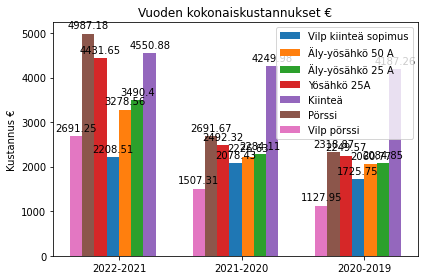

In [10]:
import matplotlib.pyplot as plt
import numpy as np
 
#Uncomment to get image in separate window    
#%matplotlib tk
    
labels = []
for vuosi in data_lista:
    labels.append(vuosi)

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, vilp_kiinteä, width, label='Vilp kiinteä sopimus')
rects2 = ax.bar(x + width/2, äly_yösähkö_50A, width, label='Äly-yösähkö 50 A')
rects3 = ax.bar(x + width + width/2, äly_yösähkö_25A, width, label='Äly-yösähkö 25 A')
rects4 = ax.bar(x - width - width/2, yösähkö_25A, width, label='Yösähkö 25A')
rects5 = ax.bar(x + (2*width) + width/2, kiinteä, width, label='Kiinteä')
rects6 = ax.bar(x - (2*width) - width/2, pörssi, width, label='Pörssi')
rects7 = ax.bar(x - (3*width) - width/2, vilp_pörssi, width, label='Vilp pörssi')

ax.set_ylabel('Kustannus €')
ax.set_title('Vuoden kokonaiskustannukset €')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.bar_label(rects5, padding=3)
ax.bar_label(rects6, padding=3)
ax.bar_label(rects7, padding=3)

fig.tight_layout()

plt.show()